In [12]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [13]:
nifty = yf.download("^NSEI",start= '2020-01-01', end='2025-12-22') #("^NSEI",start= '2010-01-01', auto_adjust=True)
nifty.dropna(inplace = True)
nifty
vix = yf.download("^VIX", start= '2020-01-01', end='2025-12-22')
vix

nifty = nifty.reset_index()
vix   = vix.reset_index()

nifty = nifty[['Close','Date']].rename(columns={'Close': 'NIFTY_Close'})
vix = vix[['Close', 'Date']].rename(columns={'Close': 'VIX_Close'})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Train Range 49 1153
Test Range 1153 1429
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Running walk-forward backtest for RF...
Running walk-forward backtest for XGB...
Walk-forward RF metrics:
None
Walk-forward XGB metrics:
None
Top features (RF):
Price         Ticker
mom_5_lag1              0.267932
window                  0.144047
ma_5_20_diff            0.137208
ma_10                   0.108416
return_1                0.088893
ma_5                    0.088596
VIX                     0.086260
mom_10                  0.020785
mom_5                   0.015966
return_2                0.012615
dtype: float64
Top features (XGB):
Price          Ticker
volatility_5             0.088154
ma_5                     0.086270
window                   0.079602
return_1                 0.076402
ma_5_20_diff             0.071108
VIX                      0.068972
ma_10                    0.066922
mom_10                   0.0

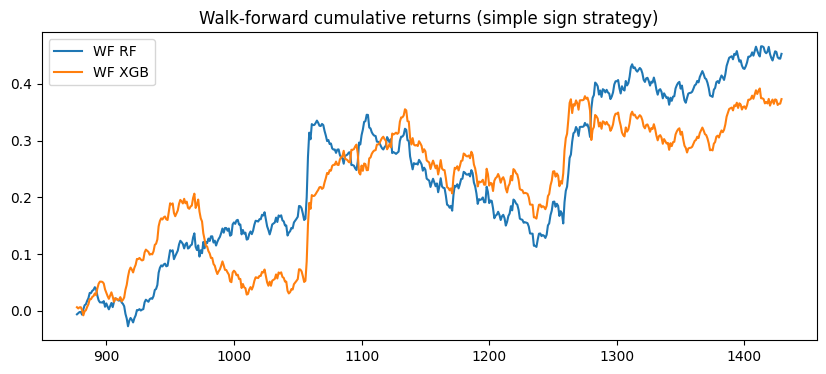

Predicted next-day return: 0.028%
Action: NO TRADE


In [24]:
df = nifty.merge(vix, on='Date', how = 'inner')


#return:
df['return'] = df['NIFTY_Close'].pct_change().shift(-1)
#Volatility:
df['volatility'] = df['NIFTY_Close'].pct_change()
df['volatility_20'] = df['volatility'].rolling(20).std()
df['volatility_5'] = df['volatility'].rolling(5).std()
#momentum:
df['mom_5'] = df['NIFTY_Close'] - df['NIFTY_Close'].shift(5)
df['mom_10'] = df['NIFTY_Close'] - df['NIFTY_Close'].shift(10)
#Moving_average:
df['ma_5'] =  df['NIFTY_Close'].rolling(5).mean()
df['ma_10'] = df['NIFTY_Close'].rolling(10).mean()
df['ma_20'] = df['NIFTY_Close'].rolling(20).mean()
df['ma_50'] = df['NIFTY_Close'].rolling(50).mean()
df['ma_5_20_diff'] = df['ma_5'] - df['ma_20']
#RSI 14:
delta = df['NIFTY_Close'].diff()
df['gain'] = delta.clip(lower = 0)
df['loss'] = -delta.clip(upper = 0)

df['VIX'] = df[('VIX_Close', '^VIX')]
def vix_to_window (vix):
    if vix > 30:
        return 7
    elif vix > 15:
        return 14
    else:
        return 20
df['window'] = df['VIX'].apply(vix_to_window)

avg_gain = []
avg_loss = []

for i in range(len(df)):
    if i == 0:
        avg_gain.append(df.loc[i,'gain'])
        avg_loss.append(df.loc[i,'loss'])
    else:
        window = df.loc[i,'window']
        alpha = 1/window

        prev_gain = avg_gain[-1]
        prev_loss = avg_loss[-1]

        avg_gain.append(alpha * df.loc[i, 'gain'] + (1 - alpha) * prev_gain)
        avg_loss.append(alpha * df.loc[i, 'loss'] + (1- alpha) * prev_loss)
df['avg_gain'] = avg_gain
df['avg_loss'] = avg_loss

rs = df['avg_gain'] / df['avg_loss']
df['rsi'] = 100 - (100/(1+rs))

#Return:
df['return_1'] = df['NIFTY_Close'].pct_change()
df['return_2'] = df['NIFTY_Close'].pct_change(2)

#Add lags:
for lags in [1,2,3]:
    df[f'mom_5_lag{lags}'] = df['mom_5'].shift(lags)

# Drop intermediate
df.drop(columns = ['volatility'], inplace = True)
df = df.dropna().copy()

if len(df) < 100:
    raise ValueError(f"Not enough data after dropna(): {len(df)} rows")

#set Target:
features = [
    'mom_5','mom_10',
    'ma_5','ma_10','ma_20','ma_50',
    'ma_5_20_diff',
    'volatility_5','volatility_20',
    'rsi',
    'window',
    'VIX',
    'return_1','return_2',
    'mom_5_lag1','mom_5_lag2','mom_5_lag3'
]

X = df[features]
y = df['return']

split_Date = df.index[int(len(df)*0.8)] # 80% will train and 20% will test split_Date is used fro indexing
X_train = X.loc[:split_Date]
X_test = X.loc[split_Date:]
y_train = y.loc[:split_Date]
y_test = y.loc[split_Date:]
print('Train Range', X_train.index.min(), X_train.index.max())
print('Test Range', X_test.index.min(), X_test.index.max())

pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators = 200, n_jobs = -1, random_state=0))
])

pipe_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(n_estimators = 300, tree_method = 'hist', verbosity = 0))
])

rf_params = {
    'model__n_estimators': [200, 300, 500],
    'model__max_depth': [3, 5, 8, 12, None],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10]
}

XGB_param = {
     'model__n_estimators': [200, 300, 500],
    'model__max_depth': [3, 5, 8, 12],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

tscv = TimeSeriesSplit(5)

rf_search = RandomizedSearchCV(
    cv = tscv,
    param_distributions= rf_params,
    estimator= pipe_rf,
    n_iter= 20,
    scoring= 'neg_mean_squared_error',
    random_state= 0,
    n_jobs= -1,
    verbose= 1
)

XGB_search = RandomizedSearchCV(
     cv = tscv,
    param_distributions= XGB_param,
    estimator= pipe_xgb,
    n_iter= 20,
    scoring= 'neg_mean_squared_error',
    random_state= 0,
    n_jobs= -1,
    verbose= 1
)


rf_search.fit(X_train, y_train)
XGB_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
best_xgb = XGB_search.best_estimator_

def evaluate_regression (y_pred, y_true, prefix = 'model'):
    r2 = r2_score(y_true, y_pred),
    mse = mean_squared_error(y_true, y_pred),
    rmse = np.sqrt(mse),
    mae = mean_absolute_error(y_true, y_pred),
    pnl = y_true * y_pred,
    ret = pnl.mean(),
    vol = pnl.std()
    sharpe = (ret/vol) * np.sqrt(252) if vol != 0 else np.nan
    print(f"{name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("Sharpe:", sharpe)
    
    y_pred_rf = best_rf.predict(X_test)
    y_pred_xgb = best_xgb.predict(X_test)

    print("RF evaluation:")
    evaluate_regression(y_test.values, y_pred_rf, prefix = 'RandomForest')
    print("XGB evaluation:")
    evaluate_regression(y_test.values, y_pred_XGB, prefix = 'XGBoost')
    

def walk_forward (X, y, model, train_frac = 0.6, step = 63):
    n = len(X)
    start = int(n*train_frac)

    preds, trues, dates = [], [], []

    for i in range (start , n, step):
        model.fit(X.iloc[:i], y.iloc[:i]) #model.fit(x_train, y_train) use the model for the previous data
        p = model.predict(X.iloc[i:i+step]) #predict the future for next 63 days
        preds.extend(p)
        trues.extend(y.iloc[i:i+step])
        dates.extend(y.iloc[i:i+step].index)
    return pd.DataFrame({'y_true': trues, 'y_pred': preds}, index= dates)

print("Running walk-forward backtest for RF...")
wf_rf = walk_forward(X, y, best_rf)
print("Running walk-forward backtest for XGB...")
wf_xgb = walk_forward(X, y, best_xgb)

def backtest_metrics (wf):
    pos = np.sign(wf['y_pred'])
    pnl = pos * wf['y_true']
    cumret = (1 + pnl).cumprod() - 1
    sharpe = (pnl.mean() / pnl.std()) * np.sqrt(252) if pnl.std() != 0 else np.nan
    maxdd = (cumret - cumret.cummax()).min()

print("Walk-forward RF metrics:")
print(backtest_metrics(wf_rf))
print("Walk-forward XGB metrics:")
print(backtest_metrics(wf_xgb))

# ========== 10) Feature importance ==========
# For RandomForest (from the fitted estimator inside pipeline)
feature_cols = X.columns
rf_model = best_rf.named_steps['model']

rf_feat_importances = rf_model.feature_importances_

# Align feature names with model input
rf_feature_names = X_train.columns[:len(rf_feat_importances)]

feat_imp = (
    pd.Series(rf_feat_importances, index=rf_feature_names)
    .sort_values(ascending=False)
)

print("Top features (RF):")
print(feat_imp.head(10))
# For XGBoost
xgb_model = best_xgb.named_steps['model']
xgb_feat_importances = xgb_model.feature_importances_

xgb_feature_names = X_train.columns[:len(xgb_feat_importances)]

feat_imp_xgb = (
    pd.Series(xgb_feat_importances, index=xgb_feature_names)
    .sort_values(ascending=False)
)

print("Top features (XGB):")
print(feat_imp_xgb.head(10))


final_model = best_xgb  # or best_rf
joblib.dump(final_model, "final_trading_model.joblib")
print("Saved final model to final_trading_model.joblib")

# ========== 12) Quick plots ==========
plt.figure(figsize=(10,4))
plt.plot((1 + (np.sign(wf_rf['y_pred']) * wf_rf['y_true'])).cumprod() - 1, label='WF RF')
plt.plot((1 + (np.sign(wf_xgb['y_pred']) * wf_xgb['y_true'])).cumprod() - 1, label='WF XGB')
plt.title('Walk-forward cumulative returns (simple sign strategy)')
plt.legend()
plt.show()

X_today = X.iloc[[-1]] 

tomorrow_return_pred = final_model.predict(X_today)[0]
signal = np.sign(tomorrow_return_pred)

THRESHOLD = 0.001
if signal == 1:
    trade_action = 'Long'
if signal == -1:
    trade_action = 'Short'
if abs(tomorrow_return_pred) < THRESHOLD:
    trade_action = "NO TRADE"

print(f"Predicted next-day return: {tomorrow_return_pred*100:.3f}%")
print("Action:", trade_action)
